# Accessing higher energy states with Qiskit Pulse

In most quantum algorithms/applications, computations are carried out over a 2-dimensional space spanned by $|0\rangle$ and $|1\rangle$. In IBM's hardware, however, there also exist higher energy states which are not typically used. The focus of this section is to explore these states using Qiskit Pulse. In particular, we demonstrate how to excite the $|2\rangle$ state and build a discriminator to classify the $|0\rangle$, $|1\rangle$ and $|2\rangle$ states.

We recommend reviewing the prior [chapter](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-openpulse.html) before going through this notebook. We also suggest reading the Qiskit Pulse specifications (Ref [1](#refs)). 

### Physics Background

We now give some additional background on the physics of transmon qubits, the basis for much of IBM's quantum hardware. These systems contain superconducting circuits composed of a Josephson junction and capacitor. For those unfamiliar with superconducting circuits, see the review [here](https://arxiv.org/pdf/1904.06560.pdf) (Ref. [2](#refs)). The Hamiltonian of this system is given by

$$
H = 4 E_C n^2 - E_J \cos(\phi),
$$

where $E_C, E_J$ denote the capacitor and Josephson energies, $n$ is the reduced charge number operator and $\phi$ is the reduced flux across the junction. We work in units with $\hbar=1$.

Transmon qubits are defined in the regime where $\phi$ is small, so we may expand $E_J \cos(\phi)$ in a Taylor series (ignoring constant terms)

$$
E_J \cos(\phi) \approx \frac{1}{2} E_J \phi^2 - \frac{1}{24} E_J \phi^4 + \mathcal{O}(\phi^6).
$$

The quadratic term $\phi^2$ defines the standard harmonic oscillator. Each additional term contributes an anharmonicity.

Using the relations $n \sim (a-a^\dagger), \phi \sim (a+a^\dagger)$ (for raising, lowering operators $a^\dagger, a$), it can be shown that the system resembles a Duffing oscillator with Hamiltonian
$$
H = \omega a^\dagger a + \frac{\alpha}{2} a^\dagger a^\dagger a a,
$$

where $\omega$ gives the $0\rightarrow1$ excitation frequency ($\omega \equiv \omega^{0\rightarrow1}$) and $\alpha$ is the anharmonicity between the $0\rightarrow1$ and $1\rightarrow2$ frequencies ($\alpha \equiv \omega^{1\rightarrow2} - \omega^{0\rightarrow1}$). Drive terms can be added as needed. 

If we choose to specialize to the standard 2-dimensional subspace, we can make $|\alpha|$ sufficiently large or use special control techniques to suppress the higher energy states.

# Contents

0. [Getting started](#importing)
1. [Discriminating the 0 and 1 states](#discrim01)
    1. [0->1 Frequency Sweep](#freqsweep01)
    2. [0->1 Rabi Experiment](#rabi01)
    3. [Build the 0,1 discriminator](#builddiscrim01)
2. [Discriminating the 0, 1 and 2 states](#discrim012)
    1. [Computing the 1->2 Frequency](#freq12)
        1. [1->2 Frequency Sweep using the sideband method](#sideband12)
    2. [1->2 Rabi Experiment](#rabi12)
    3. [Build the 0, 1, 2 discriminator](#builddiscrim012)
4. [References](#refs)

## 0. Getting Started <a id="importing"></a>

We begin by importing dependencies and defining some default variable values. We choose qubit 0 to run our experiments. We perform our experiments on the publicly available single qubit device `ibmq_armonk`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.library import Waveform

from qiskit.tools.monitor import job_monitor

In [2]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
%matplotlib inline

from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt

backend_defaults = backend.defaults()

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze
default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

# scale data (specific to each device)
scale_factor = 1e-14

# number of shots for our experiments
NUM_SHOTS = 1024

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

Qubit 0 has an estimated frequency of 4.97165779296814 GHz.


We define some additional helper functions.

In [3]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return (int(num) - (int(num)%16))

Next we include some default parameters for drive pulses and measurement. We pull the `measure` command from the instruction schedule map (from backend defaults), so that it is updated with new calibrations.

In [4]:
# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt

In [5]:
# Find out which measurement map index is needed for this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [6]:
# Get default measurement pulse from instruction schedule map
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

## 1. Discriminating the $|0\rangle$ and $|1\rangle$ states <a id="discrim01"></a>

In this section, we build a discriminator for our standard $|0\rangle$ and $|1\rangle$ states. The job of the discriminator is to take `meas_level=1` complex data and classify it into the standard $|0\rangle$ and $|1\rangle$ states (`meas_level=2`). This will replicate much of the work of the prior [chapter](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-openpulse.html). These results are necessary for exciting the higher energy states which are the focus of this notebook.

### 1A. 0->1 Frequency Sweep  <a id="freqsweep01"></a>

The first step in building a discriminator is to calibrate our qubit frequency, as done in the prior chapter.

In [7]:
def create_ground_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the ground state. 
    Depending on drive power this can reveal the 0->1 frequency or the 0->2 frequency. 
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Raised if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try to do this.
    Returns:
        Qobj: Program for ground freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
    
    # print information on the sweep
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")
    
    # Define the drive pulse
    ground_sweep_drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                                  sigma=drive_sigma,
                                                  amp=drive_power,
                                                  name='ground_sweep_drive_pulse')
    # Create the base schedule
    schedule = pulse.Schedule(name='Frequency sweep starting from ground state.')
    
    schedule |= pulse.Play(ground_sweep_drive_pulse, drive_chan)
    schedule |= measure << schedule.duration
    
    # define frequencies for the sweep
    schedule_freqs = [{drive_chan: freq} for freq in freqs]

    # assemble the program
    # Note: we only require a single schedule since each does the same thing;
    # for each schedule, the LO frequency that mixes down the drive changes
    # this enables our frequency sweep
    ground_freq_sweep_program = assemble(schedule,
                                         backend=backend, 
                                         meas_level=1,
                                         meas_return='avg',
                                         shots=NUM_SHOTS,
                                         schedule_los=schedule_freqs)
    
    return ground_freq_sweep_program

In [8]:
# We will sweep 40 MHz around the estimated frequency, with 75 frequencies
num_freqs = 75
ground_sweep_freqs = default_qubit_freq + np.linspace(-20*MHz, 20*MHz, num_freqs)
ground_freq_sweep_program = create_ground_freq_sweep_program(ground_sweep_freqs, drive_power=0.1)

The frequency sweep will go from 4.95165779296814 GHz to 4.99165779296814 GHz using 75 frequencies. The drive power is 0.1.


In [16]:
# ground_freq_sweep_job=backend.retrieve_job('60b35e074e242774f62cd9e8')
ground_freq_sweep_job = backend.run(ground_freq_sweep_program)

In [17]:
print(ground_freq_sweep_job.job_id())
job_monitor(ground_freq_sweep_job)

6100da3f91714fbe3228d547
Job Status: job has successfully run


In [18]:
# Get the job data (average)
ground_freq_sweep_data = get_job_data(ground_freq_sweep_job, average=True)

We fit our data to a Lorentzian curve and extract the calibrated frequency.

In [19]:
def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit."""
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [24]:
# do fit in Hz
(ground_sweep_fit_params, 
 ground_sweep_y_fit) = fit_function(ground_sweep_freqs,
                                   ground_freq_sweep_data, 
                                   lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                   [7, 4.925*GHz, 0.1*GHz, 3*GHz] # initial parameters for curve_fit
                                   )

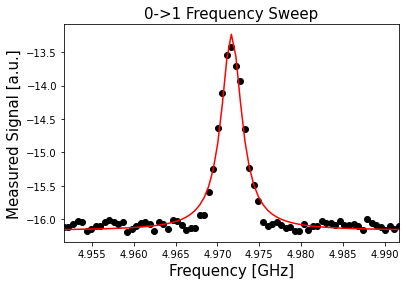

In [25]:
# Note: we are only plotting the real part of the signal
plt.scatter(ground_sweep_freqs/GHz, ground_freq_sweep_data, color='black')
plt.plot(ground_sweep_freqs/GHz, ground_sweep_y_fit, color='red')
plt.xlim([min(ground_sweep_freqs/GHz), max(ground_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("0->1 Frequency Sweep", fontsize=15)
plt.show()

In [26]:
_, cal_qubit_freq, _, _ = ground_sweep_fit_params
print(f"We've updated our qubit frequency estimate from "
      f"{round(default_qubit_freq/GHz, 7)} GHz to {round(cal_qubit_freq/GHz, 7)} GHz.")

We've updated our qubit frequency estimate from 4.9716578 GHz to 4.9716749 GHz.


### 1B. 0->1 Rabi Experiment <a id="rabi01"></a>

Next, we perform a Rabi experiment to compute the $0\rightarrow1 ~ \pi$ pulse amplitude. Recall, a $\pi$ pulse is a pulse that takes us from the $|0\rangle$ to $|1\rangle$ state (a $\pi$ rotation on the Bloch sphere).

In [27]:
# experimental configuration
num_rabi_points = 50 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [28]:
# Create schedule
rabi_01_schedules = []
# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_01_pulse = pulse_lib.gaussian(duration=drive_samples, 
                                       amp=drive_amp, 
                                       sigma=drive_sigma, 
                                       name='rabi_01_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule |= pulse.Play(rabi_01_pulse, drive_chan)
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    rabi_01_schedules.append(schedule)

In [29]:
# Assemble the schedules into a program
# Note: We drive at the calibrated frequency.
rabi_01_expt_program = assemble(rabi_01_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: cal_qubit_freq}]
                                               * num_rabi_points)

In [30]:
rabi_01_job = backend.run(rabi_01_expt_program)

In [31]:
print(rabi_01_job.job_id())
job_monitor(rabi_01_job)

6100dac8be5079036c2b2dd5
Job Status: job has successfully run


In [32]:
# Get the job data (average)
rabi_01_data = get_job_data(rabi_01_job, average=True)

In [33]:
def baseline_remove(values):
    """Center data around 0."""
    return np.array(values) - np.mean(values)

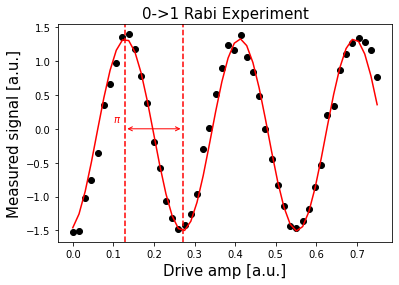

In [37]:
# Note: Only real part of data is plotted
rabi_01_data = np.real(baseline_remove(rabi_01_data))
(rabi_01_fit_params, 
 rabi_01_y_fit) = fit_function(drive_amps,
                               rabi_01_data, 
                               lambda x, A, B, drive_01_period, phi: (A*np.cos(2*np.pi*x/drive_01_period - phi) + B),
                               [4, -4, 0.25, 0])

plt.scatter(drive_amps, rabi_01_data, color='black')
plt.plot(drive_amps, rabi_01_y_fit, color='red')

drive_01_period = rabi_01_fit_params[2] 
# account for phi in computing pi amp
pi_amp_01 = (drive_01_period/2/np.pi) *(np.pi+rabi_01_fit_params[3])

plt.axvline(pi_amp_01, color='red', linestyle='--')
plt.axvline(pi_amp_01+drive_01_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_01+drive_01_period/2, 0), xytext=(pi_amp_01,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_01-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('0->1 Rabi Experiment', fontsize=15)
plt.show()

In [38]:
print(f"Pi Amplitude (0->1) = {pi_amp_01}")

Pi Amplitude (0->1) = 0.12930894526115308


Using these results, we define our $0\rightarrow1$ $\pi$ pulse.

In [39]:
pi_pulse_01 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_01, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_01')

### 1C. Build the 0,1 discriminator <a id="builddiscrim01"></a>

Now that we have our calibrated frequency and $\pi$ pulse, we can build a discriminator for $|0\rangle$ and $1\rangle$ states. The discriminator works by taking `meas_level=1` data in the IQ plane and classifying it into a $|0\rangle$ or a $1\rangle$.

The $|0\rangle$ and $|1\rangle$ states form coherent circular "blobs" in the IQ plane, which are known as centroids. The center of the centroid defines the exact, no-noise IQ point for each state. The surrounding cloud shows the variance in the data, which is generated from a variety of noise sources.

We apply a machine learning technique, Linear Discriminant Analysis, to discriminate (distinguish) between $|0\rangle$ and $|1\rangle$. This is a common technique for classifying qubit states.

Our first step is to get the centroid data. To do so, we define two schedules (recalling that our system is in the $|0\rangle$ state to start): 
1. Measure the $|0\rangle$ state directly (obtain $|0\rangle$ centroid).
2. Apply a $\pi$ pulse and then measure (obtain $|1\rangle$ centroid).

In [40]:
# Create the two schedules

# Ground state schedule
zero_schedule = pulse.Schedule(name="zero schedule")
zero_schedule |= measure

# Excited state schedule
one_schedule = pulse.Schedule(name="one schedule")
one_schedule |= pulse.Play(pi_pulse_01, drive_chan) 
one_schedule |= measure << one_schedule.duration

In [41]:
# Assemble the schedules into a program
IQ_01_program = assemble([zero_schedule, one_schedule],
                          backend=backend,
                          meas_level=1,
                          meas_return='single',
                          shots=NUM_SHOTS,
                          schedule_los=[{drive_chan: cal_qubit_freq}] * 2)

In [42]:
IQ_01_job = backend.run(IQ_01_program)

In [43]:
print(IQ_01_job.job_id())
job_monitor(IQ_01_job)

6100db83ebe62eadb432923e
Job Status: job has successfully run


In [44]:
# Get job data (single); split for zero and one
IQ_01_data = get_job_data(IQ_01_job, average=False)
zero_data = IQ_01_data[0]
one_data = IQ_01_data[1]

In [45]:
def IQ_01_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for |0>, |1>. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')

    # Plot a large dot for the average result of the zero and one states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1 discrimination", fontsize=15)

Below, we display the IQ plot. The blue centroid denotes the $|0\rangle$ state, while the red centroid denotes the $|1\rangle$ state. (Note: If the plot looks off, rerun the notebook)

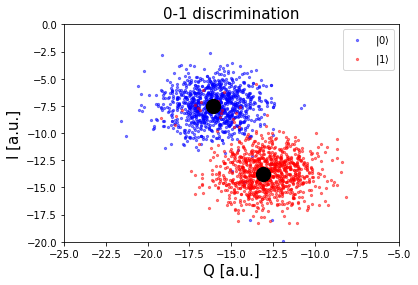

In [48]:
x_min = -25
x_max = -5
y_min = -20
y_max = 0
IQ_01_plot(x_min, x_max, y_min, y_max)

Now it is time to actually build the discriminator. As mentioned above, we will use a machine learning technique called Linear Discriminant Analysis (LDA). LDA classifies an arbitrary data set into a set of categories (here $|0\rangle$, $|1\rangle$) by maximizing the distance between the means of each category and minimizing the variance within each category. For further detail, see [here](https://scikit-learn.org/stable/modules/lda_qda.html#id4) (Ref. [3](#refs)). 

LDA generates a line called a separatrix. Depending on which side of the separatrix a given data point is on, we can determine which category it belongs to. In our example, one side of the separatrix corresponds to $|0\rangle$ states and the other to $|1\rangle$ states.

We train our model using the first half of our data and test it on the second half. We use `scikit.learn` for an implementation of LDA; in a future release, this functionality will be added released directly into Qiskit-Ignis (see  [here](https://github.com/Qiskit/qiskit-ignis/tree/master/qiskit/ignis/measurement/discriminator)). 

We begin by reshaping our result data into a format suitable for discrimination. 

In [49]:
def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i]=[np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

In [50]:
# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)  

IQ_01_data = np.concatenate((zero_data_reshaped, one_data_reshaped))
print(IQ_01_data.shape) # verify IQ data shape

(2048, 2)


Next, we split our training and testing data. We test using a state vector with our expected results (an array of `0`'s for the ground schedule and `1`s for the excited schedule).

In [51]:
# construct vector w/ 0's and 1's (for testing)
state_01 = np.zeros(NUM_SHOTS) # shots gives number of experiments
state_01 = np.concatenate((state_01, np.ones(NUM_SHOTS)))
print(len(state_01))

# Shuffle and split data into training and test sets
IQ_01_train, IQ_01_test, state_01_train, state_01_test = train_test_split(IQ_01_data, state_01, test_size=0.5)

2048


Finally, we set up our model and train it. The accuracy of our fit is printed.

In [52]:
# Set up the LDA
LDA_01 = LinearDiscriminantAnalysis()
LDA_01.fit(IQ_01_train, state_01_train)

LinearDiscriminantAnalysis()

In [53]:
# test on some simple data 
print(LDA_01.predict([[0,0], [10, 0]]))

[0. 1.]


In [54]:
# Compute accuracy
score_01 = LDA_01.score(IQ_01_test, state_01_test)
print(score_01)

0.9794921875


The last step is to plot the separatrix. 

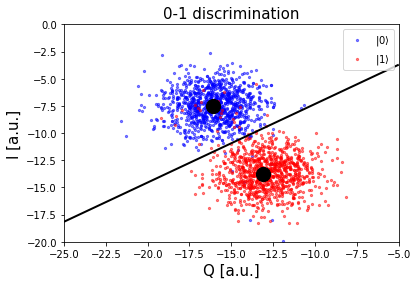

In [55]:
# Plot separatrix on top of scatter
def separatrixPlot(lda, x_min, x_max, y_min, y_max, shots):
    nx, ny = shots, shots

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='black')

IQ_01_plot(x_min, x_max, y_min, y_max)
separatrixPlot(LDA_01, x_min, x_max, y_min, y_max, NUM_SHOTS)

We see how each side of the separatrix corresponds to a centroid (and hence a state). Given a point in the IQ plane, our model checks which side of the separatrix it lies on and returns the corresponding state. 

## 2. Discriminating the $|0\rangle$, $|1\rangle$ and $|2\rangle$ states <a id="discrim012"></a> 

Now that we have calibrated the $0, 1$ discriminator, we move on to exciting higher energy states. Specifically, we focus on exciting the $|2\rangle$ state and building a discriminator to classify $|0\rangle$, $|1\rangle$ and $2\rangle$ states from their respective IQ data points. The procedure for even higher states ($|3\rangle$, $|4\rangle$, etc.) should be similar, but we have not tested them explicitly.

The process for building the higher state discriminator is as follows:
1. Compute the $1\rightarrow2$ frequency.
2. Conduct a Rabi experiment to obtain the $\pi$ pulse amplitude for $1\rightarrow2$. To do this, we first apply a $0\rightarrow1$ $\pi$ pulse to get from the $|0\rangle$ to the $|1\rangle$ state. Then, we do a sweep of drive amplitudes at the $1\rightarrow2$ frequency obtained above.
3. Construct 3 schedules:\
    a. Zero schedule: just measure the ground state.\
    b. One schedule: apply a $0\rightarrow1$ $\pi$ pulse and measure.\
    c. Two schedule: apply a $0\rightarrow1$ $\pi$ pulse, then a $1\rightarrow2$ $\pi$ pulse and measure.
4. Separate the data from each schedule into training and testing sets and construct an LDA model for discrimination.

### 2A. Computing the 1->2 frequency <a id="freq12"></a>

The first step in our calibration is to compute the frequency needed to go from the $1\rightarrow2$ state. There are two methods to do this:
1. Do a frequency sweep from the ground state and apply very high power. If the applied power is large enough, two peaks should be observed. One at the $0\rightarrow1$ frequency found in section [1](#discrim01) and one at the $0\rightarrow2$ frequency. The $1\rightarrow2$ frequency can be obtained by taking the difference of the two. Unfortunately, for `ibmq_armonk`, the maximum drive power of $1.0$ is not sufficient to see this transition. Instead, we turn to the second method.
2. Excite the $|1\rangle$ state by applying a $0\rightarrow1$ $\pi$ pulse. Then perform the frequency sweep over excitations of the $|1\rangle$ state. A single peak should be observed at a frequency lower than the $0\rightarrow1$ frequency which corresponds to the $1\rightarrow2$ frequency.

#### 1->2 Frequency Sweep using the sideband method <a id="sideband12"></a>

We follow the second method described above. To drive the $0\rightarrow 1$ $\pi$ pulse, we require a local oscillator (LO) frequency given by the calibrated $0\rightarrow1$ frequency `cal_qubit_freq` (see construction of the Rabi $\pi$ pulse in section [1](#discrim01)). To sweep the range for the $1\rightarrow2$ frequency, however, we require varying the LO frequency. Unfortunately, the Pulse specification requires a single LO frequency per schedule. 

To resolve this, we set the LO frequency to `cal_qubit_freq` and multiply a sine function onto the $1\rightarrow2$ pulse at `freq-cal_qubit_freq`, where `freq` is the desired scan frequency. Applying the sinusoidal sideband, as it's known, enables us to change the LO frequency without manually setting it when assembling the program.

In [56]:
def apply_sideband(pulse, freq):
    """Apply a sinusoidal sideband to this pulse at frequency freq.
    Args:
        pulse (SamplePulse): The pulse of interest.
        freq (float): LO frequency for which we want to apply the sweep.
    Return:
        SamplePulse: Pulse with a sideband applied (oscillates at difference between freq and cal_qubit_freq).
    """
    # time goes from 0 to dt*drive_samples, sine arg of form 2*pi*f*t
    t_samples = np.linspace(0, dt*drive_samples, drive_samples)
    sine_pulse = np.sin(2*np.pi*(freq-cal_qubit_freq)*t_samples) # no amp for the sine
    
    # create sample pulse w/ sideband applied
    # Note: need to make sq_pulse.samples real, multiply elementwise
    sideband_pulse = Waveform(np.multiply(np.real(pulse.samples), sine_pulse), name='sideband_pulse')
    
    return sideband_pulse    

We wrap the logic for assembling the program in a method and run our program.

In [57]:
def create_excited_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the |1> state. 
    This allows us to obtain the 1->2 frequency. We get from the |0> to |1>
    state via a pi pulse using the calibrated qubit frequency. To do the 
    frequency sweep from |1> to |2>, we use a sideband method by tacking
    a sine factor onto the sweep drive pulse.
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Thrown if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try more than 75 frequencies.
    Returns:
        Qobj: Program for freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
        
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")

    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                        sigma=drive_sigma,
                                        amp=drive_power,
                                        name='base_12_pulse')
    schedules = []
    for jj, freq in enumerate(freqs):
        
        # add sideband to gaussian pulse
        freq_sweep_12_pulse = apply_sideband(base_12_pulse, freq)
        
        # add commands to schedule
        schedule = pulse.Schedule(name="Frequency = {}".format(freq))

        # Add 0->1 pulse, freq sweep pulse and measure
        schedule |= pulse.Play(pi_pulse_01, drive_chan)
        schedule |= pulse.Play(freq_sweep_12_pulse, drive_chan) << schedule.duration 
        schedule |= measure << schedule.duration # shift measurement to after drive pulses

        schedules.append(schedule)

    num_freqs = len(freqs)
    
    # draw a schedule
    display(schedules[-1].draw(channels=[drive_chan, meas_chan], label=True, scale=1.0))
    
    # assemble freq sweep program 
    # Note: LO is at cal_qubit_freq for each schedule; accounted for by sideband
    excited_freq_sweep_program = assemble(schedules,
                                          backend=backend, 
                                          meas_level=1,
                                          meas_return='avg',
                                          shots=NUM_SHOTS,
                                          schedule_los=[{drive_chan: cal_qubit_freq}]
                                                         * num_freqs)
    
    return excited_freq_sweep_program

The frequency sweep will go from 4.5716748743500935 GHz to 5.001674874350094 GHz using 75 frequencies. The drive power is 0.3.


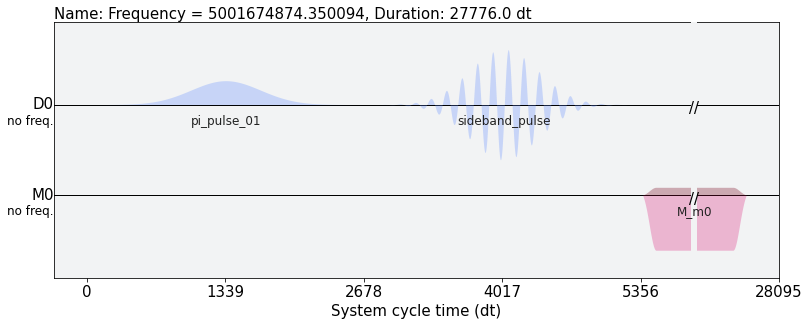

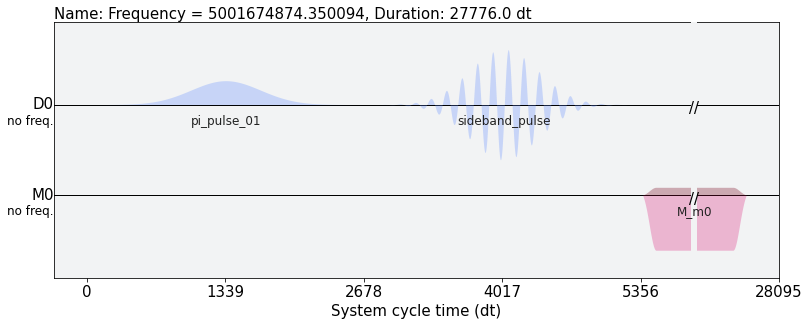

In [58]:
# sweep 400 MHz below 0->1 frequency to catch the 1->2 frequency
num_freqs = 75
excited_sweep_freqs = cal_qubit_freq + np.linspace(-400*MHz, 30*MHz, num_freqs)
excited_freq_sweep_program = create_excited_freq_sweep_program(excited_sweep_freqs, drive_power=0.3)

# Plot an example schedule to make sure it's valid

In [59]:
excited_freq_sweep_job = backend.run(excited_freq_sweep_program)

In [60]:
print(excited_freq_sweep_job.job_id())
job_monitor(excited_freq_sweep_job)

6100dbe43301ca1ddab119bc
Job Status: job has successfully run


In [61]:
# Get job data (avg)
excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True)

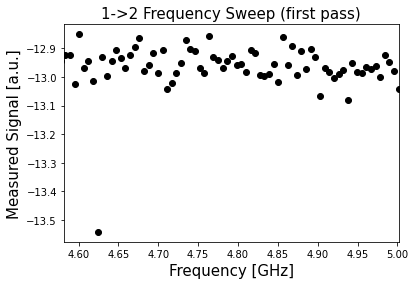

In [62]:
# Note: we are only plotting the real part of the signal
plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.xlim([min(excited_sweep_freqs/GHz)+0.01, max(excited_sweep_freqs/GHz)]) # ignore min point (is off)
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (first pass)", fontsize=15)
plt.show()

We see a maximum around $4.64$ GHz. There are a few spurious minima, but they are too large to be the $1\rightarrow2$ frequency. The maximum corresponds the $1\rightarrow2$ frequency. 

Using a relative maxima function, we compute the value of this point exactly. This gives an estimate for the $1\rightarrow2$ frequency.

In [63]:
# Prints out relative maxima frequencies in output_data; height gives lower bound (abs val)
def rel_maxima(freqs, output_data, height): 
    """
    Prints out relative maxima frequencies in output_data (can see peaks); height gives upper bound (abs val).
    Be sure to set the height properly or the peak will be ignored!
    Args:
        freqs (list): frequency list
        output_data (list): list of resulting signals
        height (float): upper bound (abs val) on a peak
    Returns:
        list: List containing relative maxima frequencies
    """
    peaks, _ = find_peaks(output_data, height)
    print("Freq. dips: ", freqs[peaks])
    return freqs[peaks]

In [73]:
maxima = rel_maxima(excited_sweep_freqs, np.real(excited_freq_sweep_data), 10)
# approx_12_freq = maxima
approx_12_freq = 4.625 * GHz

Freq. dips:  []


We now use the estimate obtained above to do a refined sweep (i.e., much smaller range). This will allow us to obtain a more accurate value for the $1\rightarrow2$ frequency. We sweep $20$ MHz in each direction.

The frequency sweep will go from 4.605 GHz to 4.645 GHz using 75 frequencies. The drive power is 0.3.


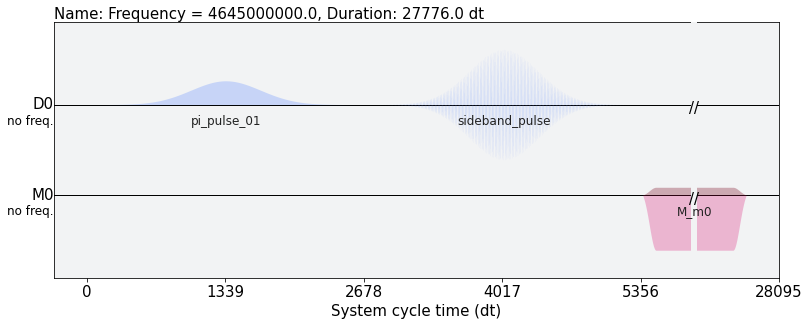

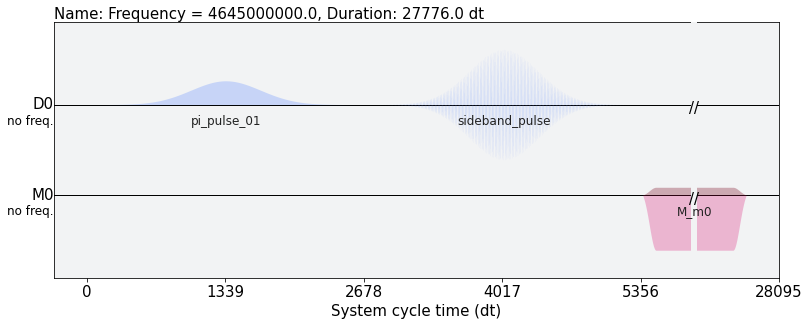

In [74]:
# smaller range refined sweep

num_freqs = 75
refined_excited_sweep_freqs = approx_12_freq + np.linspace(-20*MHz, 20*MHz, num_freqs)
refined_excited_freq_sweep_program = create_excited_freq_sweep_program(refined_excited_sweep_freqs, drive_power=0.3)

In [75]:
refined_excited_freq_sweep_job = backend.run(refined_excited_freq_sweep_program)

In [76]:
print(refined_excited_freq_sweep_job.job_id())
job_monitor(refined_excited_freq_sweep_job)

6100e28201497946013a0fcb
Job Status: job has successfully run


In [77]:
# Get the refined data (average)
refined_excited_freq_sweep_data = get_job_data(refined_excited_freq_sweep_job, average=True)

Let's plot and fit the refined signal, using the standard Lorentzian curve.

In [78]:
# do fit in Hz
(refined_excited_sweep_fit_params, 
 refined_excited_sweep_y_fit) = fit_function(refined_excited_sweep_freqs,
                                     refined_excited_freq_sweep_data, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-12, 4.625*GHz, 0.05*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

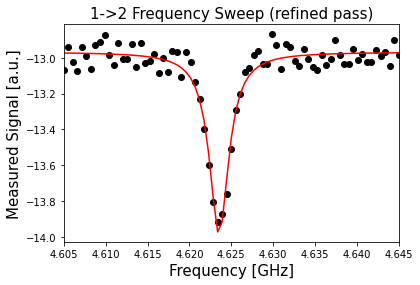

In [79]:
# Note: we are only plotting the real part of the signal
plt.scatter(refined_excited_sweep_freqs/GHz, refined_excited_freq_sweep_data, color='black')
plt.plot(refined_excited_sweep_freqs/GHz, refined_excited_sweep_y_fit, color='red')
plt.xlim([min(refined_excited_sweep_freqs/GHz), max(refined_excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

In [80]:
_, qubit_12_freq, _, _ = refined_excited_sweep_fit_params
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")

Our updated estimate for the 1->2 transition frequency is 4.6235414 GHz.


### 2B. 1->2 Rabi Experiment  <a id="rabi12"></a>

Now that we have a good estimate for the $1\rightarrow2$ frequency, we perform a Rabi experiment to obtain the $\pi$ pulse amplitude for the $1\rightarrow2$ transition. To do so, we apply a $0\rightarrow1$ $\pi$ pulse and then sweep over drive amplitudes at the $1\rightarrow2$ frequency (using the sideband method).

In [81]:
# experimental configuration
num_rabi_points = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [82]:
# Create schedule
rabi_12_schedules = []

# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    
    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                       sigma=drive_sigma,
                                       amp=drive_amp,
                                       name='base_12_pulse')
    # apply sideband at the 1->2 frequency
    rabi_12_pulse = apply_sideband(base_12_pulse, qubit_12_freq)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule |= pulse.Play(pi_pulse_01, drive_chan) # 0->1
    schedule |= pulse.Play(rabi_12_pulse, drive_chan) << schedule.duration # 1->2 Rabi pulse
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    
    rabi_12_schedules.append(schedule)

In [83]:
# Assemble the schedules into a program
# Note: The LO frequency is at cal_qubit_freq to support the 0->1 pi pulse;
# it is modified for the 1->2 pulse using sidebanding
rabi_12_expt_program = assemble(rabi_12_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: cal_qubit_freq}]
                                               * num_rabi_points)

In [84]:
rabi_12_job = backend.run(rabi_12_expt_program)

In [85]:
print(rabi_12_job.job_id())
job_monitor(rabi_12_job)

6100ebf2e03c2a4a72cab6c8
Job Status: job has successfully run


In [86]:
# Get the job data (average)
rabi_12_data = get_job_data(rabi_12_job, average=True)

We plot and fit our data as before.

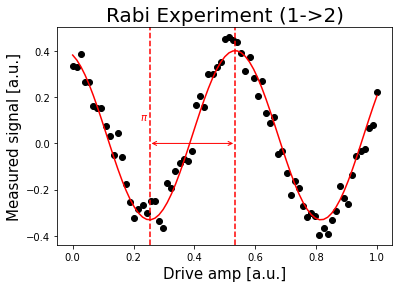

In [133]:
# Note: We only plot the real part of the signal.
rabi_12_data = np.real(baseline_remove(rabi_12_data))
(rabi_12_fit_params, 
 rabi_12_y_fit) = fit_function(drive_amps,
                            rabi_12_data, 
                            lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                            [3, 0.5, 0.5, 0])

plt.scatter(drive_amps, rabi_12_data, color='black')
plt.plot(drive_amps, rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2]
# account for phi in computing pi amp
pi_amp_12 = (drive_12_period/2/np.pi) *(np.pi+rabi_12_fit_params[3])

plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()

In [134]:
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")
print(f"Pi Amplitude (1->2) = {pi_amp_12}")

Our updated estimate for the 1->2 transition frequency is 4.6235414 GHz.
Pi Amplitude (1->2) = 0.25248079319037475


With this information, we can define our $1\rightarrow2$ $\pi$ pulse (making sure to add a sideband at the $1\rightarrow2$ frequency).

In [105]:
pi_pulse_12 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_12, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_12')
# make sure this pulse is sidebanded
pi_pulse_12 = apply_sideband(pi_pulse_12, qubit_12_freq)

### 2C. Build the 0, 1, 2 discriminator <a id="builddiscrim012"></a>

Finally, we build our discriminator for the $|0\rangle$, $|1\rangle$ and $|2\rangle$ states. The procedure is analogous to section [1](#discrim01), however now we add an additional schedule for the $|2\rangle$ state.

As a review, our three schedules are (again, recalling that our system starts in the $|0\rangle$ state): 
1. Measure the $|0\rangle$ state directly (obtain $|0\rangle$ centroid).
2. Apply $0\rightarrow1$ $\pi$ pulse and then measure (obtain $|1\rangle$ centroid).
3.  Apply $0\rightarrow1$ $\pi$ pulse, then $1\rightarrow2$ $\pi$ pulse, then measure (obtain $|2\rangle$ centroid).

In [106]:
# Create the three schedules

# Ground state schedule
zero_schedule = pulse.Schedule(name="zero schedule")
zero_schedule |= measure

# Excited state schedule
one_schedule = pulse.Schedule(name="one schedule")
one_schedule |= pulse.Play(pi_pulse_01, drive_chan)
one_schedule |= measure << one_schedule.duration

# Excited state schedule
two_schedule = pulse.Schedule(name="two schedule")
two_schedule |= pulse.Play(pi_pulse_01, drive_chan)
two_schedule |= pulse.Play(pi_pulse_12, drive_chan) << two_schedule.duration
two_schedule |= measure << two_schedule.duration

We construct the program and plot the centroids in the IQ plane.

In [107]:
# Assemble the schedules into a program
IQ_012_program = assemble([zero_schedule, one_schedule, two_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=NUM_SHOTS,
                           schedule_los=[{drive_chan: cal_qubit_freq}] * 3)

In [108]:
IQ_012_job = backend.run(IQ_012_program)

In [109]:
print(IQ_012_job.job_id())
job_monitor(IQ_012_job)

6100ee29e03c2a914dcab6d0
Job Status: job has successfully run


In [110]:
# Get job data (single); split for zero, one and two
IQ_012_data = get_job_data(IQ_012_job, average=False)
zero_data = IQ_012_data[0]
one_data = IQ_012_data[1]
two_data = IQ_012_data[2]

In [111]:
def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data), 
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

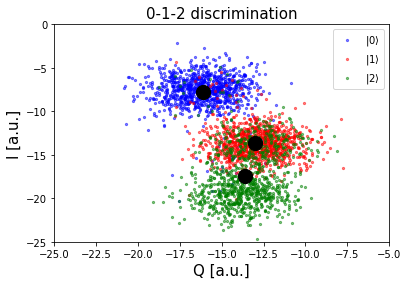

In [125]:
x_min = -25
x_max = -5
y_min = -25
y_max = 0
IQ_012_plot(x_min, x_max, y_min, y_max)

We now observe a third centroid corresponding to the $|2\rangle$ state. (Note: If the plot looks off, rerun the notebook.)

With this data, we can build our discriminator. Again, we use `scikit.learn` and Linear Discriminant Analysis (LDA).

We begin by shaping the data for LDA.

In [126]:
# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)  
two_data_reshaped = reshape_complex_vec(two_data)  

IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
print(IQ_012_data.shape) # verify IQ data shape

(3072, 2)


Next, we split our training and testing data (again, half and half). The testing data is a vector containing an array of `0`'s (for the zero schedule, `1`'s (for the one schedule) and `2`'s (for the two schedule).

In [127]:
# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(NUM_SHOTS) # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2*np.ones(NUM_SHOTS)))
print(len(state_012))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)

3072


Finally, we set up our model and train it. The accuracy of our fit is printed.

In [128]:
# Set up the LDA
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)

LinearDiscriminantAnalysis()

In [129]:
# test on some simple data 
print(LDA_012.predict([[0, 0], [-10, 0], [-15, -5]]))

[1. 0. 0.]


In [130]:
# Compute accuracy
score_012 = LDA_012.score(IQ_012_test, state_012_test)
print(score_012)

0.833984375


The last step is to plot the separatrix. 

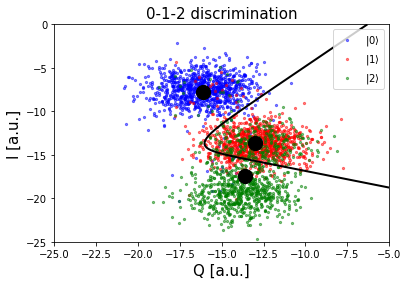

In [131]:
IQ_012_plot(x_min, x_max, y_min, y_max)
separatrixPlot(LDA_012, x_min, x_max, y_min, y_max, NUM_SHOTS)

Now that we have 3 centroids, the separatrix is no longer a line, but rather a curve containing a combination of two lines. In order to discriminate between $|0\rangle$, $|1\rangle$ and $|2\rangle$ states, our model checks where the IQ point lies relative to the separatrix and classifies the point accordingly.

## 3. References <a id="refs"></a>

1. D. C. McKay, T. Alexander, L. Bello, M. J. Biercuk, L. Bishop, J. Chen, J. M. Chow, A. D. C ́orcoles, D. Egger, S. Filipp, J. Gomez, M. Hush, A. Javadi-Abhari, D. Moreda, P. Nation, B. Paulovicks, E. Winston, C. J. Wood, J. Wootton, and J. M. Gambetta, “Qiskit backend specifications for OpenQASM and OpenPulse experiments,” 2018, https://arxiv.org/abs/1809.03452.
2. Krantz, P. et al. “A Quantum Engineer’s Guide to Superconducting Qubits.” Applied Physics Reviews 6.2 (2019): 021318, https://arxiv.org/abs/1904.06560.
3. Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011, https://scikit-learn.org/stable/modules/lda_qda.html#id4.

In [132]:
import qiskit.tools.jupyter
%qiskit_version_table